In [1]:
# Use this cell to regroup all your imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import set_config; set_config(display='diagram')

In [54]:
from sklearn.compose import make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

In [446]:
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.compose import ColumnTransformer
import math
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LinearRegression

# 🏆 Le Wagon Kaggle Batch Challenge

<img src='https://github.com/lewagon/data-images/blob/master/ML/kaggle-batch-challenge.png?raw=true' width=600>

🏆 Welcome to your first Kaggle competition!

Your objective is to **submit online an answer** to the open competition [House Prices - Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)

- Fortunately, you have already come across the house dataset in the bootcamp!
- You will be semi-guided up to a **baseline model**
- Only after will you be free to improve & refine your models
- We will approach the problem through **pipelines** (the best practice to take!)

A word on Kaggle:
- Kaggle will rank your submission amongst all participants!
- But don't worry, everyone is publicly removed from the leaderboard after 2 months
- You can make to 10 submissions per day

🧹 Today is the perfect day to practice keeping your long notebook **tidy** 🧹
- "Collapse all headings" from the "command palette" (Cmd + Shift + P)
- Stay idempotent (restart & run all should never crash)
- Name and delete variables carefully

## Setup Kaggle

👉 Create an account on Kaggle if you want to participate in the competition. 

👉 Join the [House Prices Challenge](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data) 

👉 Write down your Kaggle `username` the [result spreadsheet here](https://docs.google.com/spreadsheets/d/1ZEBKwa_k1Ytb0WCOh-Nopq3eaezwBNu1SAqKXEXRguc/edit#gid=0) (pick the correct batch!)

**Your whole class will compete as a group against the team of TAs**

## Load

We have already downloaded for you everything from Kaggle into your current notebook folder:
- `train.csv` is your (1460 * 81) training set containing `X` and `y`
- `test.csv` is your (1459 * 80) testing set without the associated target `y` 😈
- `sample_submission.csv` describing the format required to submit your answer
- `data_description.txt` describing all columns

Your goal is to predict the `y_pred` missing from your test set and submit it to discover your test_score & ranking

❓ Load the train dataset in a DataFrame `data` and create your `X` and `y`. Inspect their shape

In [6]:
!ls

Makefile                        houses_kaggle_competition.ipynb
README.md                       tests
data


In [73]:
data = pd.read_csv("data/train.csv")
data = data.drop(columns = 'Id')
y = data['SalePrice']
X = data.drop(columns = 'SalePrice')
X.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


# 🐣 1. BASELINE

## 1.1 Initial feature overview

80 features is too much to deal with one-by-one for a first baseline pipeline! Let's treat them solely based on their `dtype`:

❓ How many numerical features vs. categorical features do we have? 

In [34]:
cat_col = make_column_selector(dtype_include=['object'])
X_cat = X[cat_col]

❓ Store the Series `feat_categorical_nunique` containing the number of **unique values** for each categorical feature in our training set. How many unique categories are there in total ?

In [41]:
feat_categorical_nunique = {col:X[col].nunique() for col in X_cat}
feat_categorical_nunique = pd.Series(feat_categorical_nunique)
feat_categorical_nunique

MSZoning          5
Street            2
Alley             2
LotShape          4
LandContour       4
Utilities         2
LotConfig         5
LandSlope         3
Neighborhood     25
Condition1        9
Condition2        8
BldgType          5
HouseStyle        8
RoofStyle         6
RoofMatl          8
Exterior1st      15
Exterior2nd      16
MasVnrType        4
ExterQual         4
ExterCond         5
Foundation        6
BsmtQual          4
BsmtCond          4
BsmtExposure      4
BsmtFinType1      6
BsmtFinType2      6
Heating           6
HeatingQC         5
CentralAir        2
Electrical        5
KitchenQual       4
Functional        7
FireplaceQu       5
GarageType        6
GarageFinish      3
GarageQual        5
GarageCond        5
PavedDrive        3
PoolQC            3
Fence             4
MiscFeature       4
SaleType          9
SaleCondition     6
dtype: int64

🤔 If we were to `OneHotEncode` all categorical features, our feature matrix `X_preproc` would become pretty big and spare, with almost 300 (highly correlated) features for only 1400 observations. Ideally, we should aim at feeding our model with ~50 features max (📚 Read this [rule of thumb](https://datascience.stackexchange.com/a/11480/98300))

We know 2 main strategies to reduce the number of categorical features post-preprocessing:
- **[Remove](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection)** features that bring too little explanation to our model. This may require statistical analysis of feature importance 
- **[Ordinally encode](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html)** (instead of one-hot-encode) categorical features into integers. However this forces a notion of "order" (1>2>3...) that can be detrimental if not set properly!

❓ Plot the **histogram** of number of unique value per categorical feature. Do you see some quick wins?

<AxesSubplot:>

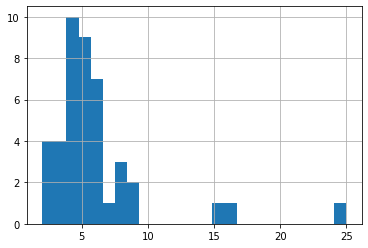

In [68]:
feat_categorical_nunique.hist(bins=25)

💡 As a starter, what about simply **removing** all features that have **7 unique values or more**, and one-hot-encode every others? Let's keep ordinal encoding and statistical feature selection for the next iteration of our pipeline.

❓ Store features names to OHE in a list `feat_categorical_small` below. How many features will be OHE?

In [69]:
feat_categorical_small = feat_categorical_nunique[feat_categorical_nunique<7]
feat_categorical_small.sum()

147

In [70]:
# YOUR CODE HERE

🧪 Test your code below (and clear the cell once it passed)

In [71]:
from nbresult import ChallengeResult
result = ChallengeResult('features_overview',
    n=len(feat_categorical_small))
result.write(); print(result.check())

============================= test session starts ==============================
platform darwin -- Python 3.8.12, pytest-6.2.5, py-1.11.0, pluggy-1.0.0 -- /Users/humbert/.pyenv/versions/lewagon/bin/python3
cachedir: .pytest_cache
rootdir: /Users/humbert/code/HumbertMonnot/data-challenges/05-ML/07-Ensemble-Methods/01-Houses-Kaggle-Competition
plugins: anyio-3.4.0, dash-2.0.0
collecting ... collected 1 item

tests/test_features_overview.py::TestFeaturesOverview::test_feat_categorical_small PASSED [100%]

============================== 1 passed in 0.01s ===============================


💯 You can commit your code:

git add tests/features_overview.pickle

git commit -m 'Completed features_overview step'

git push origin master


## 1.2 Baseline pipe

### a) Preprocessing

❓ Let's code the basic preprocessing pipeline described below. Save it under `preproc_baseline`.

For categorical features
- Simple-Impute with most frequent values
- One-Hot-Encode features that have less than 7 unique values to start with
- Drop all others features


As for numerical features
- Simple-Impute with strategy 'mean'
- Min-Max Scale 


<details>
    <summary>ℹ️ Pro tips</summary>

If you are confident, you can try sklearn's shorter syntax `make_pipeline` or `make_column_transformer` instead of the longer syntax `Pipeline` or `ColumnTransformer` if you want to avoid giving names manually to every steps.
</details>

In [86]:
num_col = make_column_selector(dtype_include=['float64', 'int64'])

cat_pipe = make_pipeline(SimpleImputer(strategy='most_frequent'),
                        OneHotEncoder(sparse=False, handle_unknown='ignore'))
num_pipe = make_pipeline(SimpleImputer(strategy='mean'),
                        MinMaxScaler())
preproc_baseline = ColumnTransformer([
    ("cat",cat_pipe,feat_categorical_small.index),
    ("num",num_pipe, num_col)
])

❓ Look at the **shape** of your preprocessed dataframe.

In [87]:
shape_preproc_baseline = preproc_baseline.fit_transform(X).shape

🧪 Test your code below

In [88]:
from nbresult import ChallengeResult
result = ChallengeResult('preproc_baseline',
    shape=shape_preproc_baseline)
result.write()
print(result.check())

============================= test session starts ==============================
platform darwin -- Python 3.8.12, pytest-6.2.5, py-1.11.0, pluggy-1.0.0 -- /Users/humbert/.pyenv/versions/lewagon/bin/python3
cachedir: .pytest_cache
rootdir: /Users/humbert/code/HumbertMonnot/data-challenges/05-ML/07-Ensemble-Methods/01-Houses-Kaggle-Competition
plugins: anyio-3.4.0, dash-2.0.0
collecting ... collected 1 item

tests/test_preproc_baseline.py::TestPreprocBaseline::test_shape PASSED   [100%]

============================== 1 passed in 0.02s ===============================


💯 You can commit your code:

git add tests/preproc_baseline.pickle

git commit -m 'Completed preproc_baseline step'

git push origin master


### b) Add estimator

❓ Add a simple Decision Tree model to your `preproc_baseline` and store it to `pipe_baseline` variable.

In [89]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

tree_rgs = DecisionTreeRegressor(max_depth=5)

pipe_baseline = make_pipeline(preproc_baseline, tree_rgs)

### c) Cross-Validate

❓ Read the Kaggle [contest evaluation rules](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview/evaluation) 
- Which performance metric do you need? Is it readily available in sklearn?
- We will need to create our custom `sklearn.metrics.scorer` object so as to pass to any cross-validation or grid search as below


👉 Create a scorer called `rmsle` using [`make_scorer`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html) that can be passed as a value for the `scoring` kwarg as below:
```python
cross_val_score(pipe_baseline, X, y, cv=5, scoring=rmsle)
```
👉 Create also the negative version `rmsle_neg` which is best when _maximized_. This will come handy later as `GridSearchCV` always tries to _maximize_ a score
```python
GridSearchCV(pipe_baseline, param_grid=..., cv=5, scoring=rmse_neg)
```

$$\text{RMSLE}(y, \hat{y}) = \sqrt{\frac{1}{n_\text{samples}} \sum_{i=0}^{n_\text{samples} - 1} (\log_e (1 + y_i) - \log_e (1 + \hat{y}_i) )^2.}$$

In [136]:
def rmsle_f(y,y_pred,**kwargs):
    log_true = np.log(1+y)
    log_pred = np.log(1+y_pred)
    sigma = ((log_true-log_pred)**2).sum()
    return math.sqrt(sigma/len(y))

def rmsle_f_inv(y,y_pred,**kwargs):
    return - rmsle_f(y,y_pred,**kwargs)

rmsle = make_scorer(rmsle_f,)
rmsle_neg = make_scorer(rmsle_f_inv)

❓5-fold cross_validate your `pipe_baseline` using this metric to get a first glance at your baseline perf.    

Store your mean score as `score_baseline`

In [114]:
score_baseline = cross_val_score(pipe_baseline, X, y, scoring = rmsle).mean()
score_baseline

0.20411695584786332

### d) Predict baseline

❓ Predict `y_pred_baseline` from the Kaggle `test.csv` dataset you stored in the `data` folder.

In [102]:
data_test = pd.read_csv("data/test.csv")
data_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [106]:
pipe_baseline.fit(X,y)
y_pred_baseline = pipe_baseline.predict(data_test)
y_pred_baseline

array([119154.315625  , 138382.26      , 181321.25700935, ...,
       138382.26      , 119154.315625  , 211563.63636364])

❓ Finally, store your CSV ready to be submitted as `submission_baseline.csv` in the `data` folder. Read carefully the Kaggle required format and test it below (you don't need to submit this baseline online for now).

In [116]:
to_exp = pd.concat([data_test['Id'], pd.Series(y_pred_baseline, name = 'SalePrice')], axis = 1)
to_exp.to_csv("data/submission_baseline.csv", index = False)

🧪 Test your code

In [117]:
from nbresult import ChallengeResult
tmp = pd.read_csv("data/submission_baseline.csv")
result = ChallengeResult('submission_baseline',
    score_baseline = score_baseline,
    submission_shape = tmp.shape,
    submission_columns = list(tmp.columns),
    submission_dtypes = str(list(tmp.dtypes)),
)
result.write()
print(result.check())

============================= test session starts ==============================
platform darwin -- Python 3.8.12, pytest-6.2.5, py-1.11.0, pluggy-1.0.0 -- /Users/humbert/.pyenv/versions/lewagon/bin/python3
cachedir: .pytest_cache
rootdir: /Users/humbert/code/HumbertMonnot/data-challenges/05-ML/07-Ensemble-Methods/01-Houses-Kaggle-Competition
plugins: anyio-3.4.0, dash-2.0.0
collecting ... collected 4 items

tests/test_submission_baseline.py::TestSubmissionBaseline::test_score_baseline PASSED [ 25%]
tests/test_submission_baseline.py::TestSubmissionBaseline::test_submission_columns PASSED [ 50%]
tests/test_submission_baseline.py::TestSubmissionBaseline::test_submission_dtypes PASSED [ 75%]
tests/test_submission_baseline.py::TestSubmissionBaseline::test_submission_shape PASSED [100%]

============================== 4 passed in 0.10s ===============================


💯 You can commit your code:

git add tests/submission_baseline.pickle

git commit -m 'Completed submission_baseline step'



# 🏋️‍♀️ 2. ITERATIONS 

🎉 🎉 Congratulation for having fully pipelined a basline model! You will see now how easier it is to iterate and improve performance 🚀

- Your goal is to improve your prediction and submit it by **16h30 max online**
- We suggested you some improvements below: **Pick up your fights** and **incrementally** improve your pipeline as you see fit

**Estimators**

- **Tree-based ensembles (must try today)**: Probably the best suited for many categorical-features problems
- Stacking !
- XGBoost !

**Preprocessing** (once your first ensemble models works)

- Ordinal Encoding of categorical features with a hidden notion of order in their values (e.g. "bad", "average", good")
- Statistical Feature Selection to remove useless features (avoid overfitting and reduce train time)
- Predict log(SalePrice) instead?
- ...

## 2.1 Preprocessing Iteration ♲ 
(**⚠️ come back here only after you have iterated on your estimators on section 2.2)**

⏩ Collapse me if you don't use me!

### a) Ordinal Encoding (1h)

❓ Look at the following feature below. Couldn't it be encoded numerically in a wise manner?
```
ExterQual: Evaluates the quality of the material on the exterior 
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor
```

💡 Luckily, the `OrdinalEncoder` and its argument `categories`  allows us to do just that. Check it out below and make sure to understand how this works

In [219]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
# Define specific order for features
# Note: if you change this order, it will change the output for .transform()
feature_A_sorted_values = ['bad', 'average', 'good'] 
feature_B_sorted_values = ['dirty', 'clean', 'new']

encoder = OrdinalEncoder(
    categories=[
        feature_A_sorted_values,
        feature_B_sorted_values
    ],
    handle_unknown="use_encoded_value",
    unknown_value=-1
)

# Just some random training data
XX = [
    ['good', 'dirty'],
    ['bad', 'new'],
    ['average', 'clean'],
]

encoder.fit_transform(XX)



array([[2., 0.],
       [0., 2.],
       [1., 1.]])

---
❓ **Your turn**: split your categorical preprocessor into

- `preproc_ordinal` to ordinally encode **some features** of your choice
- `preproc_nominal` to one hot encode the other ones


<details>
    <summary>Hints</summary>

- You won't be able to avoid hard-coding names and ordered values of features! Be tidy!
- It's a good practice to sort alphabetically your features to avoid bad surprises
</details>

In [209]:
feat_cat_qual = ['HeatingQC','ExterCond','FireplaceQu','BsmtQual','BsmtCond','KitchenQual',
                 'GarageQual','PoolQC']

In [459]:
feat_ordinal_dict = {
    # considers "missing" as "neutral"
    "BsmtExposure": ['missing', 'No', 'Mn', 'Av', 'Gd'],
    "BsmtFinType1": ['missing', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    "BsmtFinType2": ['missing', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    "Electrical": ['missing', 'Mix', 'FuseP', 'FuseF', 'FuseA', 'SBrkr'],
    "ExterQual": ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
    "Fence": ['missing', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv'],
    "Functional": ['missing', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],
    "GarageCond": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "GarageFinish": ['missing', 'Unf', 'RFn', 'Fin'],
    "LandContour": ['missing', 'Low', 'Bnk', 'HLS', 'Lvl'],
    "LandSlope": ['missing', 'Sev', 'Mod', 'Gtl'],
    "LotShape": ['missing', 'IR3', 'IR2', 'IR1', 'Reg'],
    "PavedDrive": ['missing', 'N', 'P', 'Y'],
}

feat_ordinal = sorted(feat_ordinal_dict.keys()) # sort alphabetically
feat_ordinal_values_sorted = [feat_ordinal_dict[i] for i in feat_ordinal]

In [460]:
feat_cat_nonqual = list(set(feat_categorical_nunique)-set(feat_ordinal)-set(feat_cat_qual))

In [461]:

encoder_ordinal = OrdinalEncoder(
    categories=feat_ordinal_values_sorted,
    dtype= np.int64,
    handle_unknown="use_encoded_value",
    unknown_value=-1 # Considers unknown values as worse than "missing"
)

preproc_ordinal = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    encoder_ordinal,
    MinMaxScaler()
)

preproc_ordinal

Pipeline(steps=[('simpleimputer',
                 SimpleImputer(fill_value='missing', strategy='constant')),
                ('ordinalencoder',
                 OrdinalEncoder(categories=[['missing', 'No', 'Mn', 'Av', 'Gd'],
                                            ['missing', 'Unf', 'LwQ', 'Rec',
                                             'BLQ', 'ALQ', 'GLQ'],
                                            ['missing', 'Unf', 'LwQ', 'Rec',
                                             'BLQ', 'ALQ', 'GLQ'],
                                            ['missing', 'Mix', 'FuseP', 'FuseF',
                                             'FuseA', 'SBrkr'],
                                            ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
                                            ['mis...
                                            ['missing', 'Sev', 'Maj2', 'Maj1',
                                             'Mod', 'Min2', 'Min1', 'Typ'],
                                            ['missing', 'Po', 'Fa', 'TA', 'Gd',
                                             'Ex'],
                                            ['missing', 'Unf', 'RFn', 'Fin'],
                                            ['missing', 'Low', 'Bnk', 'HLS',
                                             'Lvl'],
                                            ['missing', 'Sev', 'Mod', 'Gtl'],
                                            ['missing', 'IR3', 'IR2', 'IR1',
                                             'Reg'],
                                            ['missing', 'N', 'P', 'Y']],
                                dtype=<class 'numpy.int64'>,
                                handle_unknown='use_encoded_value',
                                unknown_value=-1)),
                ('minmaxscaler', MinMaxScaler())])

In [462]:
feature_sorted_values = ['Po','Fa','TA','Gd','Ex']
qual_encoder = OrdinalEncoder(
    categories=[feature_sorted_values for _ in range(8)],
    handle_unknown="use_encoded_value",
    unknown_value=-1)
X[feat_cat_qual]

,HeatingQC,ExterCond,FireplaceQu,BsmtQual,BsmtCond,KitchenQual,GarageQual,PoolQC
0,Ex,TA,NaN,Gd,TA,Gd,TA,NaN
1,Ex,TA,TA,Gd,TA,TA,TA,NaN
2,Ex,TA,TA,Gd,TA,Gd,TA,NaN
3,Gd,TA,Gd,TA,Gd,Gd,TA,NaN
4,Ex,TA,TA,Gd,TA,Gd,TA,NaN
...,...,...,...,...,...,...,...,...
1455,Ex,TA,TA,Gd,TA,TA,TA,NaN
1456,TA,TA,TA,Gd,TA,TA,TA,NaN
1457,Ex,Gd,Gd,TA,Gd,Gd,TA,NaN
1458,Gd,TA,NaN,TA,TA,Gd,TA,NaN


In [472]:
cat_no_qual_pipe = make_pipeline(SimpleImputer(strategy='most_frequent'),
                        OneHotEncoder(sparse=False, handle_unknown='ignore'))

cat_qual_pipe = make_pipeline(qual_encoder,MinMaxScaler())

num_pipe = make_pipeline(SimpleImputer(strategy='mean'),
                        MinMaxScaler())

preproc = ColumnTransformer([("cat_qual",cat_qual_pipe,feat_cat_qual),
                             ("cat_ord",preproc_ordinal,feat_ordinal),
                            ("num",num_pipe, num_col),
                            ("cat_no_qual",cat_no_qual_pipe,feat_cat_noqual),
                            ],remainder="drop")

In [474]:
pd.DataFrame(preproc.fit_transform(X,y)).head()

,0,1,2,3,4,5,6,7,8,9,...,159,160,161,162,163,164,165,166,167,168
0,1.00,0.5,0.0,0.8,0.75,0.666667,0.6,0.0,0.25,1.000000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.00,0.5,0.6,0.8,0.75,0.333333,0.6,0.0,1.00,0.833333,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.00,0.5,0.6,0.8,0.75,0.666667,0.6,0.0,0.50,1.000000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.75,0.5,0.8,0.6,1.00,0.666667,0.6,0.0,0.25,0.833333,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.00,0.5,0.6,0.8,0.75,0.666667,0.6,0.0,0.75,1.000000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### b) Statistical Feature Selection (~30min)

Our goal is to remove the least interesting features, to limit overfitting and shorten training time.  

🔥 We will make use of sklearn's [feature selection](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection) transformers directly in your pipeline!

❗️ We recommend you to **try only option 1 today to start with**. Option 2 and 3 will be corrected in Recap

#### (option 1 - recommended) <font color=green>Univariate</font> feature selection based on their mutual information with target `y`

- Feel free to add a `SelectPercentile` filter at the end of your `preproc` pipeline.
- This will filter-out features that, - taken individually - least explain your target!
- The statistical test we recommend to pass to SelectPercentile is the `mutual_info_regression`

<details>
    <summary markdown='span'>🤔 Mutual Information?</summary>

- Mutual information is a *statistical* distance between two probability distributions.
- Correlation is a *linear* distance between two random variables.
- Mutual information is more general and measures the reduction of uncertainty in Y after observing X.
- On the other hand, if you already know you are working with variables that are smooth (like continuous numerical variables), sometimes correlation may tell you more about them, for instance if their relationship is monotonic.

See [animation](https://twitter.com/ari_seff/status/1409296508634152964)
</details>

In [313]:
from sklearn.feature_selection import SelectPercentile, chi2, f_regression

In [281]:
feature_sorted_values = ['Po','Fa','TA','Gd','Ex']
qual_encoder = OrdinalEncoder(
    categories=[feature_sorted_values for _ in range(8)],
    handle_unknown="use_encoded_value",
    unknown_value=-3)

feat_cat_noqual = list(set(feat_categorical_small.index) - set(feat_cat_qual))

cat_no_qual_pipe = make_pipeline(SimpleImputer(strategy='most_frequent'),
                        OneHotEncoder(sparse=False, handle_unknown='ignore'))

cat_qual_pipe = make_pipeline(qual_encoder)

num_pipe = make_pipeline(SimpleImputer(strategy='mean'),
                        MinMaxScaler())

preproc = ColumnTransformer([("cat_qual",cat_qual_pipe,feat_cat_qual),
                            ("num",num_pipe, num_col),
                            ("cat_no_qual",cat_no_qual_pipe,feat_cat_noqual)])




In [258]:
pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('cat_qual',
                                    Pipeline(steps=[('ordinalencoder',
                                                     OrdinalEncoder(categories=[['Po',
                                                                                 'Fa',
                                                                                 'TA',
                                                                                 'Gd',
                                                                                 'Ex'],
                                                                                ['Po',
                                                                                 'Fa',
                                                                                 'TA',
                                                                                 'Gd',
                                               

#### (option 2) <font color=green>Multivariate</font> feature selection based their combined relationship with target `y`

🤔 We want to remove features that, when in combination with all the others, do not really help predict our target.

1️⃣ To do so, remember that we can use feature [`permutation_importance`](https://scikit-learn.org/stable/modules/permutation_importance.html) importance in combination with an estimator! It train one pipe per feature, so as to estimate which feature make our performance score *decrease* the most when shuffling it randomly. These would be our most important feature not to remove. 

Cherry on the cake, scikit-learn allows you to integrate this methodology directly into your `preproc` pipeline thanks to the `SequentialFeatureSelector` transformer: This will recursively filter-out least important features according to `feature_permutation` importance!  

However, such process can take extremely long to train when you have many features.

2️⃣ Alternatively, a faster way would be to make use of models that already outputs some measure of feature_importance when fitting them. For instance, Trees with gini-based `feature_importance_`, or Lasso regressions with L1 `coef_`. Again here, scikit-learn has coded for you a [`SelectFromModel`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html) transformer to do just that

In [0]:
# YOUR CODE HERE

#### (option 3) <font color=green>Unsupervised</font> selection: Filter based only on the properties of `X`? 

❓ A quick-win is to remove features with the lowest variance. Think about it: a feature which only takes one value is useless (and has a variance of 0).  
- Feel free to add a `VarianceThreshold` to the end of your pipeline

In [0]:
# YOUR CODE HERE

❓ Additionally, we can check for correlation between our **numerical features** only

- Use [Pearson's correlation](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) combined with a heatmap to check visually whether some **numerical** features almost entirely correlated with others. 
- Use statsmodels's `VIF` to check for feature that have the highest multicolionearity

In [0]:
# YOUR CODE HERE

❓ For **ordinal features**, we can use [Spearman's rank correlation](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient) instead to check whether some **ordinally encoded** features are almost entirely "ordered" similarily than others. Feel free to plot a heatmap again

In [0]:
# YOUR CODE HERE

❓Now, feel free to create a "filter" in your pipeline that removes any feature you want beyond a given (spearman + peasron) correlation threshold. You'll need a custom transformer class

In [0]:
# YOUR CODE HERE

### c) Target engineering (15 min)

❓ We are asked to minimize the RMS**L**E. Why don't we transform our target to directly predict its log?
- Check-out the histogram of the target `y`.
- Normally distributed variables should be easier to predict with linear or parametric models. 
- Create `y_log` and your new performance metrics
- Don't forget at the end to take the exponential of your predictions!

In [416]:
y_log = np.log(y)

In [417]:
def rmsle_l(y_log,y_log_pred,**kwargs):
    sigma = ((y_log-y_log_pred)**2).sum()
    return math.sqrt(sigma/len(y_log))

rmsle_log = make_scorer(rmsle_l)

## 2.2 Models Iteration ♻

In [478]:
from scipy import stats
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.impute import KNNImputer

In [479]:
num_col = make_column_selector(dtype_include=['float64', 'int64'])

cat_pipe = make_pipeline(SimpleImputer(strategy='most_frequent'),
                        OneHotEncoder(sparse=False, handle_unknown='ignore'))
num_pipe = make_pipeline(KNNImputer(),
                        MinMaxScaler())
preproc_baseline = ColumnTransformer([
    ("cat",cat_pipe,feat_categorical_small.index),
    ("num",num_pipe, num_col)
])

### RandomForestRegressor, 

model = RandomForestRegressor(max_depth=None, n_estimators=200), 0.14497730618352836

model = RandomForestRegressor(max_depth=None, n_estimators=100), 0.1469525106478981

In [144]:
from sklearn.ensemble import RandomForestRegressor

In [422]:
model = RandomForestRegressor(max_depth=None, n_estimators=100)

pipe_baseline = make_pipeline(pipe_baseline, model)

score_rfr = cross_val_score(pipe_baseline, X, y, scoring = rmsle).mean()
score_rfr

TypeError: All intermediate steps should be transformers and implement fit and transform or be the string 'passthrough' 'Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('cat_qual',
                                                                   Pipeline(steps=[('ordinalencoder',
                                                                                    OrdinalEncoder(categories=[['Po',
                                                                                                                'Fa',
                                                                                                                'TA',
                                                                                                                'Gd',
                                                                                                                'Ex'],
                                                                                                               ['Po',
                                                                                                                'Fa',
                                                                                                                'TA',
                                                                                                                'Gd',
                                                                                                                'Ex'],
                                                                                                               ['Po',
                                                                                                                'Fa',
                                                                                                                'TA',
                                                                                                                'Gd',
                                                                                                                'Ex'],
                                                                                                               ['Po',
                                                                                                                'Fa',
                                                                                                                'TA',
                                                                                                                'Gd',
                                                                                                                'Ex'],
                                                                                                               ['Po',
                                                                                                                'Fa',
                                                                                                                'TA',
                                                                                                                'Gd',
                                                                                                                'Ex'],
                                                                                                               ['Po',
                                                                                                                'Fa',
                                                                                                                'TA',
                                                                                                                'Gd',
                                                                                                                'Ex'],
                                                                                                               ['Po',
                                                                                                                'Fa',
                                                                                                                'TA',
                                                                                                                'G...
                              interaction_constraints=None, learning_rate=0.01,
                              max_delta_step=None, max_depth=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=1000,
                              n_jobs=-1, num_parallel_tree=None, predictor=None,
                              random_state=None, reg_alpha=None,
                              reg_lambda=None, scale_pos_weight=None,
                              subsample=None, tree_method=None,
                              validate_parameters=None, verbosity=None))])' (type <class 'sklearn.pipeline.Pipeline'>) doesn't

In [151]:
pipe_baseline.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('cat',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('onehotencoder',
                                                     OneHotEncoder(handle_unknown='ignore',
                                                                   sparse=False))]),
                                    Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
          'LotConfig', 'LandSlope', 'BldgType', 'RoofStyle', 'MasVnrType',
          'ExterQual', 'ExterCond', 'Foundati...
          'CentralAir', 'Electrical', 'KitchenQual', 'FireplaceQu', 'GarageType',
          'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC',
          'Fence', 'MiscFeature', 'SaleCondition'],
         dtype='object')),
                  

In [152]:
grid = {'randomforestregressor__max_depth': stats.randint(1,100), 
        'randomforestregressor__n_estimators':[50,100,200]}

search = RandomizedSearchCV(pipe_baseline, ,
                           scoring = rmsle_neg,
                        
                           n_iter = 200,
                           n_jobs=-1)

search.fit(X,y)
search.best_score_

KeyboardInterrupt: 

### Stacking

In [161]:
from sklearn.linear_model import LinearRegression, SGDRegressor, ElasticNet, Lasso

In [160]:
from sklearn.ensemble import StackingClassifier, StackingRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

In [200]:
ensemble = StackingRegressor(
    estimators = [("rf", RandomForestRegressor(max_depth=5)),
                  ("knn", KNeighborsRegressor(n_neighbors=1)),
                  ("sgd", XGBRegressor(base_score=-0.14, n_jobs = -1, n_estimators = 300, learning_rate=0.01)),
                  ("EN", ElasticNet())],
    final_estimator = LinearRegression(n_jobs=-1))

pipe_baseline = make_pipeline(preproc_baseline, ensemble)

score_baseline = cross_val_score(pipe_baseline, X, y, scoring = rmsle).mean()
score_baseline


[CV 1/5] END .xgbregressor__learning_rate=0.001;, score=2.381 total time=   2.9s
[CV 1/5] END xgbregressor__learning_rate=0.001;, score=-2.381 total time=   3.1s
[CV 3/5] END ....xgbregressor__learning_rate=1;, score=-0.217 total time=   2.8s
[CV 3/5] END xgbregressor__learning_rate=0.001;, score=-2.368 total time=   2.8s
[CV 2/5] END ....xgbregressor__learning_rate=1;, score=-0.230 total time=   3.1s
[CV 1/5] END .xgbregressor__learning_rate=0.01;, score=-0.121 total time=  40.2s
[CV 1/2] END .xgbregressor__learning_rate=0.001;, score=2.363 total time=   1.4s
[CV 1/5] END ..xgbregressor__learning_rate=0.01;, score=0.479 total time=   3.4s
[CV 3/5] END .....xgbregressor__learning_rate=1;, score=0.217 total time=   2.9s
[CV 2/5] END xgbregressor__learning_rate=0.001;, score=-2.341 total time=   2.8s
[CV 4/5] END .xgbregressor__learning_rate=0.01;, score=-0.452 total time=   2.5s
[CV 1/5] END .xgbregressor__learning_rate=0.01;, score=-0.479 total time=   3.6s
[CV 1/5] END xgbregressor__l

0.1344529642739872

In [177]:
search = GridSearchCV(pipe_baseline, 
                            param_grid={
                                'pipe__knn__n_neighbors': [5,7,9,11,13,15], 
                                'pipe__sgd__alpha':[0.001,0.1,10]},
                           scoring = rmsle,
                           n_jobs=-1,
                           cv=4)

search.fit(X,y)
search.best_score_

ValueError: Invalid parameter pipe for estimator Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'BldgType', 'RoofStyle', 'MasVnrTy...
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x11353d9a0>)])),
                ('stackingregressor',
                 StackingRegressor(estimators=[('rf',
                                                RandomForestRegressor(max_depth=5)),
                                               ('knn', KNeighborsRegressor()),
                                               ('sgd', SGDRegressor()),
                                               ('EN', ElasticNet())],
                                   final_estimator=LinearRegression(n_jobs=-1)))]). Check the list of available parameters with `estimator.get_params().keys()`.

### XGBoost

XGBRegressor(max_depth=None, n_estimators=100, learning_rate=0.1) -> 0.1328192108196274

'xgbregressor__learning_rate': 0.01 -> 0.13127761703785965

In [318]:
from xgboost import XGBRegressor
from sklearn.feature_selection import SelectPercentile, chi2, f_regression, SelectKBest, mutual_info_regression

In [496]:
cat_no_qual_pipe = make_pipeline(SimpleImputer(strategy='most_frequent'),
                        OneHotEncoder(sparse=False, handle_unknown='ignore'))

cat_qual_pipe = make_pipeline(qual_encoder,MinMaxScaler())

num_pipe = make_pipeline(SimpleImputer(strategy='mean'),
                        MinMaxScaler())

preproc = ColumnTransformer([("cat_qual",cat_qual_pipe,feat_cat_qual),
                             ("cat_ord",preproc_ordinal,feat_ordinal),
                            ("num",num_pipe, num_col),
                            ("cat_no_qual",cat_no_qual_pipe,feat_cat_noqual),
                            ],remainder="drop")

pipe = make_pipeline(preproc, SelectPercentile(mutual_info_regression, percentile = 50))

In [490]:
len(feat_cat_noqual)+len(feat_cat_qual)

34

In [493]:
xgb_reg = XGBRegressor(base_score = 0.131, n_jobs = -1, n_estimators = 1000, learning_rate = 0.01,)

pipe_baseline = make_pipeline(pipe, xgb_reg)

score = cross_val_score(pipe_baseline, X, y_log, scoring = rmsle_log).mean()
score

0.13357981336476907

In [486]:
pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('cat_qual',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['Po',
                                                                                               'Fa',
                                                                                               'TA',
                                                                                               'Gd',
                                                                                               'Ex'],
                                                                                              ['Po',
                                                                                               'Fa',
                                                                                               'TA',
                                                                                               'Gd',
                                                                                               'Ex'],
                                                                                              ['Po',
                                                                                               'Fa',
                                                                                               'TA',
                                                                                               'Gd',
                                                                                               'Ex'],
                                                                                              ['Po',
                                                                                               'Fa',
                                                                                               'TA',
                                                                                               'Gd',
                                                                                               'Ex'],
                                                                                              ['Po',
                                                                                               'Fa',
                                                                                               'TA',
                                                                                               'Gd',
                                                                                               'Ex']...
                                                   'ExterQual', 'MiscFeature',
                                                   'Foundation', 'Electrical',
                                                   'GarageType', 'PavedDrive',
                                                   'Utilities', 'RoofStyle',
                                                   'Street', 'BldgType',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2',
                                                   'BsmtExposure', 'MSZoning',
                                                   'LotConfig', 'LotShape',
                                                   'MasVnrType', 'LandContour',
                                                   'Fence', 'Heating',
                                                   'GarageCond'])])),
                ('selectpercentile',
                 SelectPercentile(percentile=40,
         

In [426]:
model = RandomForestRegressor(max_depth=None, n_estimators=300)

pipe_baseline = make_pipeline(pipe, model)

score_rfr = cross_val_score(pipe_baseline, X, y_log, scoring = rmsle_log).mean()
score_rfr

0.1415343392016279

In [503]:
model_en = ElasticNet(alpha=0.75)

pipe_baseline_en = make_pipeline(pipe, model_en)

score_en = cross_val_score(pipe_baseline, X, y_log, scoring = rmsle_log).mean()
score_en

0.13449389137560291

In [502]:
model_svr = SVR(C=1)

pipe_baseline_en = make_pipeline(pipe, model_svr)

score_svr = cross_val_score(pipe_baseline, X, y_log, scoring = rmsle_log).mean()
score_svr

0.13460848048558782

In [501]:
model_sg = SGDRegressor()

pipe_baseline_sg = make_pipeline(pipe, model_sg)

score_sg = cross_val_score(pipe_baseline, X, y_log, scoring = rmsle_log).mean()
score_sg

0.1344680089063974

In [500]:
from sklearn.ensemble import GradientBoostingRegressor

gboost = GradientBoostingRegressor(n_estimators=100)

pipe_gb = make_pipeline(pipe, gboost)

score_gb = cross_val_score(pipe_gb, X, y_log, scoring = rmsle_log).mean()
score_gb

0.12874838408726005

In [495]:
pipe_gb

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('cat_qual',
                                                                   Pipeline(steps=[('ordinalencoder',
                                                                                    OrdinalEncoder(categories=[['Po',
                                                                                                                'Fa',
                                                                                                                'TA',
                                                                                                                'Gd',
                                                                                                                'Ex'],
                                                                                                               ['Po',
                                                                                                                'Fa',
                                                                                                                'TA',
                                                                                                                'Gd',
                                                                                                                'Ex'],
                                                                                                               ['Po',
                                                                                                                'Fa',
                                                                                                                'TA',
                                                                                                                'Gd',
                                                                                                                'Ex'],
                                                                                                               ['Po',
                                                                                                                'Fa',
                                                                                                                'TA',
                                                                                                                'Gd',
                                                                                                                'Ex'],
                                                                                                               ['Po',
                                                                                                                'Fa',
                                                                                                                'TA',
                                                                                                                'Gd',
                                                                                                                'Ex'],
                                                                                                               ['Po',
                                                                                                                'Fa',
                                                                                                                'TA',
                                                                                                                'Gd',
                                                                                                                'Ex'],
                                                                                                               ['Po',
                                                                       

In [ ]:
from sklearn.ensemble import AdaBoostRegressor

adaboost = AdaBoostRegressor(
    DecisionTreeRegressor(max_depth=3),
    n_estimators=50)

cv_results = cross_validate(adaboost, X, y, scoring = "r2", cv=5)

plot_histogram_cv_results(cv_results)

In [499]:
sgboost = GradientBoostingRegressor(
    n_estimators=100
)

ensemble = StackingClassifier(
    estimators = [("xgb", XGBRegressor(base_score = 0.131, n_jobs = -1, n_estimators = 1000,
                                      learning_rate = 0.01,)),
                  ("svr", model_svr),
                  ("sg",model_sg),
                  ("gb", gboost)
                   ],
    final_estimator = KNeighborsRegressor(n_neighbors=15))

pipe_baseline_sg = make_pipeline(pipe, ensemble)

score_st = cross_val_score(pipe_baseline, X, y_log, scoring = rmsle_log).mean()
score_st

0.13399080039369507

### a ) Final version of the preproc pipeline
❓ We advise you to start with a fresh definition below so you can quickly update it as need be.

In [393]:
data_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [449]:
y_pred = np.exp(pipe_baseline.fit(X,y_log).predict(data_test))-1
y_pred

array([120735.47 , 162502.08 , 188213.94 , ..., 151083.47 , 116482.555,
       226242.19 ], dtype=float32)

In [406]:
len(data_test)

1459

In [407]:
len(y_pred)

1459

In [450]:
id_ = data_test['Id'] # need for final submission to kaggle
y_pred_boost = pd.DataFrame({ 'Id' : id_, 'SalePrice' : y_pred} )
y_pred_boost = y_pred_boost.set_index('Id')
y_pred_boost.to_csv('data/submission_boost.csv')#, index=False)

In [451]:
to_exp = pd.concat([data_test[['Id']], pd.Series(y_pred, name = 'SalePrice')], axis = 1)
to_exp.to_csv("data/submission_baseline3.csv", index = False)

# 🏅FINAL SUBMISSION (submit at least 30 min before Recap)

Discover your real test score by submitting on Kaggle! 

👉 Write down your test score on the [result spreadsheet here](https://docs.google.com/spreadsheets/d/1ZEBKwa_k1Ytb0WCOh-Nopq3eaezwBNu1SAqKXEXRguc/edit#gid=0) (pick the correct batch!)

In [0]:
# YOUR CODE HERE